<a href="https://colab.research.google.com/github/yunseos/lung_segmentation_pytorch/blob/main/Lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🤎엄밀히 말하면 이번 segmentation은 내가 직접 ct사진을 가지고 마스크를 만드는게 아니라, 기존에 있는 마스크와 이미지를 (어짜피 파일명은 똑같기 때문에) 할당시켜 주는 것이다.

🤎 할당만으로 끝나는 것이 아니라, 마스킹된 사진에서 왼쪽과 오른쪽을 분할해서 구분지어 주고자 한다.

In [ ]:
### 내 드라이브에 mount 시켜서 폴더 만들어주기

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
### 데이터를 내 드라이브에 다운로드

!wget https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip

--2024-03-05 13:14:54--  https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip [following]
--2024-03-05 13:14:54--  https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56097894 (53M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  53.

In [ ]:
### 압축 해제 해주기

!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
  inflating: image/resize_CHNCXR_0001_0.png  
  inflating: image/resize_CHNCXR_0002_0.png  
  inflating: image/resize_CHNCXR_0003_0.png  
  inflating: image/resize_CHNCXR_0004_0.png  
  inflating: image/resize_CHNCXR_0005_0.png  
  inflating: image/resize_CHNCXR_0006_0.png  
  inflating: image/resize_CHNCXR_0007_0.png  
  inflating: image/resize_CHNCXR_0008_0.png  
  inflating: image/resize_CHNCXR_0009_0.png  
  inflating: image/resize_CHNCXR_0010_0.png  
  inflating: image/resize_CHNCXR_0011_0.png  
  inflating: image/resize_CHNCXR_0012_0.png  
  inflating: image/resize_CHNCXR_0013_0.png  
  inflating: image/resize_CHNCXR_0014_0.png  
  inflating: image/resize_CHNCXR_0015_0.png  
  inflating: image/resize_CHNCXR_0016_0.png  
  inflating: image/resize_CHNCXR_0017_0.png  
  inflating: image/resize_CHNCXR_0018_0.png  
  inflating: image/resize_CHNCXR_0019_0.png  
  inflating: image/resize_CHNCXR_0020_0.png  
  inflating: image/resize_CHNCXR_0021_0.png  
  

In [ ]:
### 필요한 라이브러리 import

import numpy as np #수치 계산을 위한 라이브러리
import os #운영체제와 상호작용하기 위한 함수가 있는 라이브러리
from cv2 import imread, createCLAHE #이미지 대비를 향상시키기 위한 목적
import cv2 #cv2가 있어야 이미지나 비디오 파일을 읽고 쓰는 처리를 할 수 있다
from glob import glob #이건 보통 파일 시스템에서 검색할 때 사용
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread #이미지 읽기
from skimage.transform import resize #이미지 크기조정
from sklearn.model_selection import train_test_split #이미지 training, test set 나누기

import torch #파이토치 불러올 때 이렇게 쓰는듯
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
### 이미지의 특징 미리 지정하기

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
### 현재 디렉토리에서 확장자 명 빼고 이름 지정

data_path = "./" #현재 작업 디렉토리라는 뜻

files = os.listdir(os.path.join(data_path, 'image')) #이름 얻고자 하는 파일들은 현재 data_path에서 이미지에 해당하는 부분에 있다
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)
print(file_headers)

['resize_CHNCXR_0622_1', 'resize_CHNCXR_0472_1', 'resize_CHNCXR_0478_1', 'resize_CHNCXR_0060_0', 'resize_CHNCXR_0329_1', 'resize_CHNCXR_0504_1', 'resize_CHNCXR_0548_1', 'resize_CHNCXR_0285_0', 'resize_CHNCXR_0093_0', 'resize_CHNCXR_0007_0', 'resize_CHNCXR_0529_1', 'resize_CHNCXR_0361_1', 'resize_CHNCXR_0099_0', 'resize_CHNCXR_0172_0', 'resize_CHNCXR_0372_1', 'resize_CHNCXR_0297_0', 'resize_CHNCXR_0630_1', 'resize_CHNCXR_0474_1', 'resize_CHNCXR_0432_1', 'resize_CHNCXR_0041_0', 'resize_CHNCXR_0103_0', 'resize_CHNCXR_0328_1', 'resize_CHNCXR_0164_0', 'resize_CHNCXR_0291_0', 'resize_CHNCXR_0020_0', 'resize_CHNCXR_0557_1', 'resize_CHNCXR_0405_1', 'resize_CHNCXR_0593_1', 'resize_CHNCXR_0402_1', 'resize_CHNCXR_0637_1', 'resize_CHNCXR_0111_0', 'resize_CHNCXR_0325_0', 'resize_CHNCXR_0163_0', 'resize_CHNCXR_0091_0', 'resize_CHNCXR_0140_0', 'resize_CHNCXR_0539_1', 'resize_CHNCXR_0235_0', 'resize_CHNCXR_0423_1', 'resize_CHNCXR_0286_0', 'resize_CHNCXR_0449_1', 'resize_CHNCXR_0032_0', 'resize_CHNCXR_

In [ ]:
### image와 mask 데이터를 할당할 공간 만들어주기!!
### 이미지와 마스크 데이터를 저장하고 처리하기 위한 공간을 제공해준다.

X_all = torch.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=torch.float32) #첫번째요소는 총 갯수이다. 데이터 타입은 이미지이기 때문에 0~255나타낼 수 있는 8비트 정수로 지정해주는 것이다.
y_all = torch.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=torch.bool) #마스크는 채널이 하나니깐 1장인거고, 부울로 지정해준 이유는 마스크 데이터는 참, 거짓 두개만 나타내기 때문이다.

!! 아래에서 근데 굳이 저렇게 확장자 떼었다 붙였다 말고 한번에 더 코드 줄이는 방법 있나 생각. (바로 이미지path 지정하면 안됨?)

In [ ]:
### 이미지와 마스크 데이터를 위에서 할당한 공간에 넣어주기

count = 0

for fh in file_headers: #아까 위에서 만들어준 파일명들만 있는 (확장자명 제거한) 리스트
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh)) #이제 그 파일명에다가 확장자명까지 붙여주겠다는 거지
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))

    img = imread(f1)[:,:,:IMG_CHANNELS] #imread()는 이미지 불러오기다. :는 전체를 의미한다. 즉, 해석해보면, 가로세로는 원래 이미지의 값이고, 채널수만 원래 이미지의 처음값부터 우리가 지정한 3까지로 정한다는
    mask = imread(l1) #imread()로 불러오는 과정에서 넘파이배열로 변환됨. 이 함수는 openCV 라이브러리에 있고, 보통 저기 라이브러리에 있는 함수 사용해서 파일을 넘파이 배열로써 불러올 수 있다.
    mask = np.expand_dims(mask, axis=-1) #입력데이터와의 차원을 일치시키기 위해서 이렇게 정해준다. 단일채널 마스크 입력일 때는 안해도 되는데, 이미지랑 같이 처리하니깐, 마스크와 이미지의 형태를 일치시켜야된다.

    # 이미지와 마스크를 PyTorch 텐서로 변환
    img_tensor = torch.tensor(img, dtype=torch.float32) / 255.0
    mask_tensor = torch.tensor(mask, dtype=torch.float32) / 255.0  # 마스크는 이미지와 동일한 처리

    X_all[count] = img_tensor
    y_all[count] = mask_tensor

    count += 1

In [ ]:
### training set, test set 나누기

seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all.permute(0,3,1,2), y_all.permute(0,3,1,2), test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train torch.Size([361, 3, 256, 256])
X_valid torch.Size([91, 3, 256, 256])
X_test torch.Size([114, 3, 256, 256])
y_train torch.Size([361, 1, 256, 256])
y_valid torch.Size([91, 1, 256, 256])
y_test torch.Size([114, 1, 256, 256])


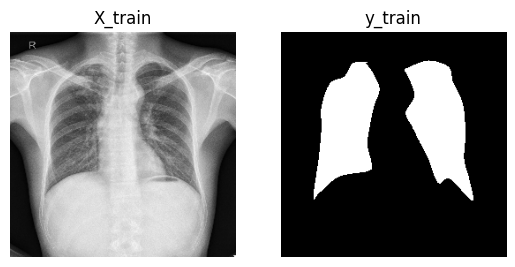

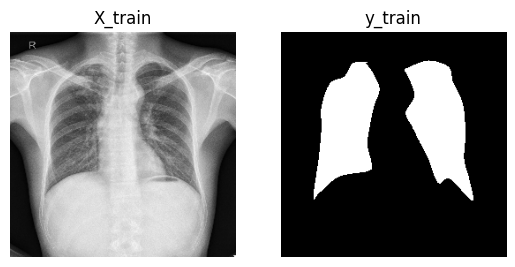

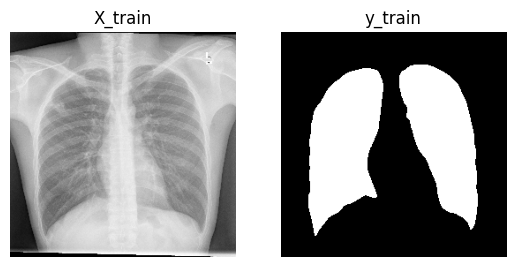

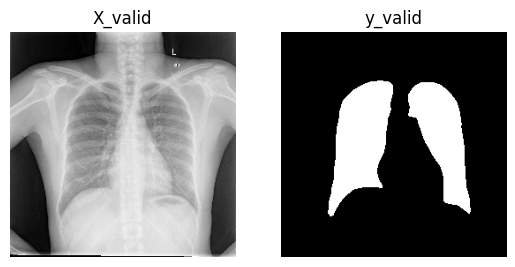

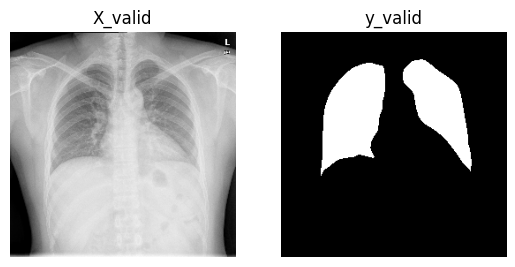

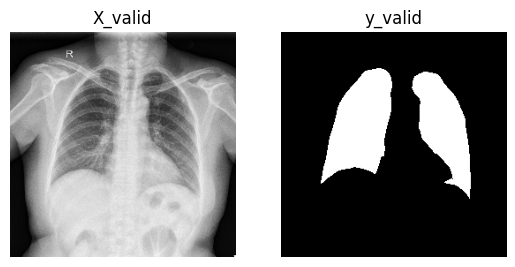

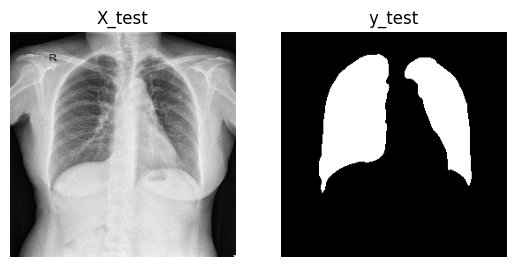

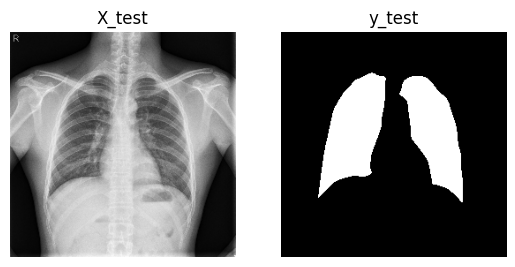

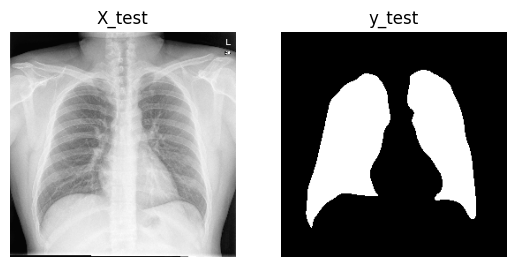

In [ ]:
### 데이터 살펴보기

def plotTrainData(a,b,c): #함수 정의하는 과정이다. 정의한 함수에서, a,b,c 순서대로 이미지 데이터, 해당이미지에 대한 라벨 데이터, 데이터의 종류 (train, valid, test)를 나타낸다.
    for i in range(3): #0,1,2를 포함하는 범위이다. 마지막 숫자가 무엇인지 헷갈리지 않기 위해 2+1로 써도 무방하다
        ix = np.random.randint(0, len(a)) #0부터 a의 배열 길이 사이에서 임의의 정수 선택. 이로써 임의의 이미지 선택이 가능하다.
        plt.subplot(1,2,1) #이 함수를 통해서 그림영역의 격자를 선택가능하다. 1*2 격자중에서 첫번째 위치를 선택
        plt.title("X_" + c) #그 위치에 X_와 데이터의 종류를 쓴다.
        plt.imshow(a[ix]) #이미지를 불러온다. 아까 랜덤으로 구한 정수를 가져옴으로써 임의의 이미지를 불러올 수 있게 되는 것이다.
        plt.axis('off') #축은 나타내지 않겠다는 것이다.
        plt.subplot(1,2,2) #첫번째 플롯에 대한 설정이 끝났기 땜시 바로 두번째 플롯에 대한 설정을 해준다.
        plt.title("y_" + c) #얘도 마찬가지로 y_에다가 c에 입력한 데이터 종류를 그대로 붙여서 나타낸다.
        plt.imshow(np.squeeze(b[ix]), 'gray') #squeeze는 크기가 1인 축을 없애주는 함수다. 아까 이미지랑 마스크 크기 맞춰야한다고 축 하나 더해준거 빼주는듯? 그레이 이미지로 나타낸다.
        plt.axis('off')
        plt.show()

plotTrainData(X_train.permute(0,2,3,1),y_train.permute(0,2,3,1), 'train')
plotTrainData(X_valid.permute(0,2,3,1),y_valid.permute(0,2,3,1), 'valid')
plotTrainData(X_test.permute(0,2,3,1),y_test.permute(0,2,3,1), 'test')
#위에서 총 3개씩만 나오라고 지정했기 때문에 train, valid, test 모두 3개씩 나온다.

In [ ]:
### 모델 생성 (파이토치에서 이미 있는 segmentation model 사용하려고 한다.) (모델을 첨부터 구축한게 아니라 이제 불러온 것이라고 할 수 있다.)

!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=308972de2fc52e8d434e32de757c39e2c2cd5e19f5c8721281f569771189d924
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c0f17d51dbe442baa18293120edb5042e70353f3c52c70a79fab4e6de35a6b90
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 3, #인풋 채널수 (1은 gray scale, 3은 RGB)
    classes = 1, #model output 채널
)

model.cuda()

In [ ]:
###학습시키기

# 1. 데이터 전처리가 앞에서 완료되었는데, 이게 끝이 아니다. DataLoader를 사용해서 데이터를 모델에 공급할 준비를 해야한다. 훈련, 검증, 테스트 데이터를 DataLoader로 변환해야 한다.
# 2. 손실함수도 정의해주어야 한다. 이미지 세그멘테이션 작업에서는 주로 cross-entropy loss나 dice loss 등이 사용된다. (왜?????? 이유 찾아보기)
# 3. 모델을 훈련하기 위하여 옵티마이저를 선택하고 초기화 해야한다. 보통 SGD, Adam, RMSprop 등이 사용된다. (왜???????? 이유 찾아보기)
# 4. 훈련 반복문 작성해주기. 주어진 배치를 모델입력으로 전달, 역전파 사용하여 가중치 업데이트 해야한다.
# 5. 검증 및 테스트.,...

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

##1. dataloader 사용해서 모델에 공급할 준비 하기

# 근데 앞에서 이미 train, valid, test을 나누어 주었었다. 근데 훈련시키기 위해서는 결국 pair을 만들어야 하는것이므로, 이미지와 마스크를 쌍으로 가지는 데이터셋을 만들어야 하는게 첫번째이다.

class CustomDataset(Dataset):
  def __init__(self, images, masks): #데이터셋의 이미지와 마스크를 클래스의 속성으로 설정하겠다는 의미
    self.images = images
    self.masks = masks

  def __len__(self): #데이터셋의 총 데이터 수를 반환 한다.
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    mask = self.masks[idx]
    return image, mask

##train 데이터 세트
train_dataset = CustomDataset(X_train, y_train)

##valid 데이터 세트
valid_dataset = CustomDataset(X_valid, y_valid)

##test 데이터 세트
test_dataset = CustomDataset(X_test, y_test)

##데이터 로더 설정
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)

##2.  손실 함수 정의
criterion = nn.CrossEntropyLoss()

##3. 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##4. train 반복문 작성해주기

epochs = 60
train_losses = []
total_steps = len (train_loader) #train dataset이 몇개인지

for epoch in range(epochs):

    running_loss = 0.0

    for i, (images, masks) in enumerate(train_loader,1):
        images = images.to(device)
        masks = masks.to(device)

        ##그래디언트 초기화
        optimizer.zero_grad()

        ##순전파 (forward pass)
        outputs = model(images)
        loss = criterion(outputs, masks.float()) # 마스크는 0 또는 1의 값을 가져야 하므로 float()로 형변환해야 한다

        ##역전파 (backward and optimize)
        loss.backward()
        optimizer.step()

         # 통계 출력
        running_loss += loss.item() * images.size(0)

    # 에폭 종료 후 훈련 손실 계산
    epoch_loss = running_loss / len(train_loader.dataset)

    print(f'Epoch [{epoch + 1}/{epochs}],Step [{i}/{total_steps}], Train Loss: {epoch_loss:.4f}')

KeyboardInterrupt: 